<a href="https://colab.research.google.com/github/orekhovsky/GenAI-mini-projects/blob/main/RAG_text2sql/RAG%20model%20comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Без векторной бд

In [ ]:
pip install gigachat transformers rouge-score -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 1.8 MB/s eta 0:00:00


In [ ]:
pip install -U langchain-community -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import ast
from langchain.chat_models.gigachat import GigaChat
from google.colab import userdata
import nltk
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import requests
import json
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-bioasq/data/passages.parquet/part.0.parquet")
df_test = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-bioasq/data/test.parquet/part.0.parquet")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-bioasq/data/passages.parquet/part.0.parquet")
df_test = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-bioasq/data/test.parquet/part.0.parquet")

# Преобразование чтобы правильно считать строку со списком релевантных id из корпуса текстов
df_test['relevant_passage_ids'] = df_test['relevant_passage_ids'].apply(ast.literal_eval)

# Функция для извленения чанков и формирования контекста для подачи в llm
def perform_retrieval(question, df, df_test):

    matching_rows = df_test[df_test['question'] == question]
    if matching_rows.empty:
        raise ValueError(f"Question '{question}' not found in df_test.")

    question_index = matching_rows.index[0]

    # Получение релевантных чанков из корпуса текстов
    relevant_passage_ids = df_test.loc[question_index, 'relevant_passage_ids']
    relevant_passages = [df.loc[i, 'passage'] for i in relevant_passage_ids]

    # Формируем контекст
    context = " ".join(relevant_passages)

    return context


## Оценка метрик

In [ ]:

nltk.download('wordnet')
nltk.download('omw-1.4')

def add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df):
    """
    Вычисляет метрики BLEU, METEOR и ROUGE для данной модели, а затем добавляет их в датафрейм.

    Args:
        model_name (str): Название модели.
        true_answer (str): Истинный ответ.
        response (str): Ответ модели.
        metrics_df (pd.DataFrame): Датафрейм с метриками.

    Returns:
        pd.DataFrame: Обновленный датафрейм с добавленными метриками.
    """
    # ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(true_answer, response)

    # BLEU
    true_tokens = true_answer.split()
    response_tokens = response.split()
    smooth_fn = SmoothingFunction().method1
    bleu_score = sentence_bleu([true_tokens], response_tokens, smoothing_function=smooth_fn)

    # METEOR
    meteor = meteor_score([true_answer.split()], response.split())

    # Создание строки с метриками
    new_row = pd.DataFrame([{
        "Model": model_name,
        "BLEU": bleu_score,
        "METEOR": meteor,
        "ROUGE-1": rouge_scores['rouge1'].fmeasure,
        "ROUGE-2": rouge_scores['rouge2'].fmeasure,
        "ROUGE-L": rouge_scores['rougeL'].fmeasure
    }])

    # Добавление строки в датафрейм
    metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

    return metrics_df

# Пример использования
columns = ["Model", "BLEU", "METEOR", "ROUGE-1", "ROUGE-2", "ROUGE-L"]
metrics_df = pd.DataFrame(columns=columns)
true_answer = df_test['answer'][0]
# # Пример данных
# model_name = "Llama 3.2-1b"
# true_answer = df_test['answer'][0]
# response = "Generated response by the model"

# # Обновление датафрейма
# metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)

# # Просмотр датафрейма
# print(metrics_df)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Сравниваемые модели

### Гигачат

In [ ]:
# Авторизация через токен
auth = userdata.get('SBER_AUTH')

# Инициализация модели GigaChat
llm = GigaChat(
    credentials=auth,
    model='GigaChat:latest',
    verify_ssl_certs=False,
    profanity_check=False
)

# Пайплайн для RAG
def perform_rag_pipeline(question, df, df_test, llm):
    # Шаг 1: Извлекаем контекст из корпуса на основе вопроса
    context = perform_retrieval(question, df, df_test)

    # Шаг 2: Входные данные для модели
    input_text = f"""
    Answer the user's question.
    Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
    Context: {context}
    Question: {question}
    Answer:"""

    # Шаг 3: Генерируем ответ
    response = llm.predict(input_text)

    return response

# Пример вопроса
q1 = 'Is Hirschsprung disease a mendelian or a multifactorial disorder?'

response = perform_rag_pipeline(q1, df, df_test, llm)
print(f"Question: {q1}")
print(f"Answer: {response}")
model_name = "Gigachat"
metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)


Question: Is Hirschsprung disease a mendelian or a multifactorial disorder?
Answer: Hirschsprung disease (HSCR) is generally considered to be a **multifactorial** disorder rather than a Mendelian inherited disease. This means that it involves the combined effects of multiple genes and environmental factors, rather than being caused by mutations in a single gene. However, there are also syndromic forms of HSCR that follow Mendelian inheritance patterns, including autosomal dominant, recessive, and polygenic inheritance.

The complexity of HSCR inheritance can be seen in the fact that both rare and common mutations contribute to the risk of the disease, often acting in combination with each other and with environmental factors. This complexity makes it challenging to define HSCR solely under a Mendelian model.


<ipython-input-30-874a1bcc5702>:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


In [ ]:
from rouge_score import rouge_scorer
true_answer = df_test['answer'][0]

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score(true_answer, response)

# Метрики (не очень, но по сути верно)
print("ROUGE-1:", scores['rouge1'])
print("ROUGE-2:", scores['rouge2'])
print("ROUGE-L:", scores['rougeL'])


ROUGE-1: Score(precision=0.26506024096385544, recall=0.36065573770491804, fmeasure=0.3055555555555556)
ROUGE-2: Score(precision=0.06097560975609756, recall=0.08333333333333333, fmeasure=0.07042253521126761)
ROUGE-L: Score(precision=0.10843373493975904, recall=0.14754098360655737, fmeasure=0.125)


### gpt-4o-mini

In [ ]:
response ="Hirschsprung disease (HSCR) is a complex disorder with both Mendelian and multifactorial aspects. While some forms of the disease, particularly the syndromic and familial types, follow Mendelian inheritance patterns (autosomal dominant, recessive, and polygenic), the more common non-syndromic forms exhibit non-Mendelian inheritance with variable expression and incomplete penetrance. Genetic studies suggest that multiple loci and genetic interactions contribute to the disease, making it a multifactorial disorder."

model_name = "gpt-4o-mini"
metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)

### Llama 3.2 1B Instruct

In [ ]:
# Авторизация через OpenRouter
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

# Функция для выполнения RAG с использованием модели Llama
def perform_rag_pipeline(question, df, df_test, api_key):
    # Шаг 1: Извлекаем контекст
    context = perform_retrieval(question, df, df_test)

    # Шаг 2: Подготовка данных для модели
    input_data = {
        "model": "meta-llama/llama-3.2-1b-instruct",
        "messages": [
            {
                "role": "user",
                "content": f"""
                Answer the user's question.
                Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
                Context: {context}
                Question: {question}
                Answer:"""
            }
        ]
    }

    # Шаг 3: Отправка запроса к API
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        data=json.dumps(input_data)
    )

    # Обработка ответа
    if response.status_code == 200:
        data = response.json()
        model_reply = data.get('choices', [{}])[0].get('message', {}).get('content', 'No content found')
        return model_reply
    else:
        raise RuntimeError(f"API request failed with status {response.status_code}: {response.text}")

# Пример вопроса
q1 = 'Is Hirschsprung disease a mendelian or a multifactorial disorder?'

response = perform_rag_pipeline(q1, df, df_test, OPENROUTER_API_KEY)
print(f"Question: {q1}")
print(f"Answer: {response}")
model_name = "Llama 3.2 1B Instruct"
metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)


Question: Is Hirschsprung disease a mendelian or a multifactorial disorder?
Answer: According to the text, Hirschsprung disease is a multifactorial disorder. It is characterized by the absence of ganglion cells in the gastrointestinal tract, and its complex inheritance pattern is suggested by the involvement of multiple genetic loci, as well as the presence of modifier genes that can influence the phenotype. The text also mentions that HSCR has a "non-mendelian inheritance pattern", indicating that it is not solely caused by a single Mendelian gene.


### "deepseek/deepseek-chat"

In [ ]:
# Авторизация через OpenRouter
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

# Функция для выполнения RAG с использованием модели Llama
def perform_rag_pipeline(question, df, df_test, api_key):
    # Шаг 1: Извлекаем контекст
    context = perform_retrieval(question, df, df_test)

    # Шаг 2: Подготовка данных для модели
    input_data = {
        "model": "deepseek/deepseek-chat",
        "messages": [
            {
                "role": "user",
                "content": f"""
                Answer the user's question.
                Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
                Context: {context}
                Question: {question}
                Answer:"""
            }
        ]
    }

    # Шаг 3: Отправка запроса к API
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        data=json.dumps(input_data)
    )

    # Обработка ответа
    if response.status_code == 200:
        data = response.json()
        model_reply = data.get('choices', [{}])[0].get('message', {}).get('content', 'No content found')
        return model_reply
    else:
        raise RuntimeError(f"API request failed with status {response.status_code}: {response.text}")

# Пример вопроса
q1 = 'Is Hirschsprung disease a mendelian or a multifactorial disorder?'

response = perform_rag_pipeline(q1, df, df_test, OPENROUTER_API_KEY)
print(f"Question: {q1}")
print(f"Answer: {response}")
model_name = "DeepSeek V3"
metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)


Question: Is Hirschsprung disease a mendelian or a multifactorial disorder?
Answer: Hirschsprung disease (HSCR) is primarily a **multifactorial disorder**, although it has both Mendelian and non-Mendelian components. The majority of cases, particularly the sporadic non-syndromic short-segment form, exhibit complex inheritance with involvement of multiple loci and variable expression. Syndromic and familial forms, however, can display Mendelian inheritance patterns, including autosomal dominant, recessive, and polygenic inheritance. The disease's phenotypic variability and incomplete penetrance further suggest the involvement of modifier genes and complex genetic interactions. Thus, HSCR is best characterized as a multifactorial disorder with contributions from both rare and common genetic variants.


### Qwen: QvQ 72B Preview

In [ ]:
# Авторизация через OpenRouter
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

# Функция для выполнения RAG с использованием модели Llama
def perform_rag_pipeline(question, df, df_test, api_key):
    # Шаг 1: Извлекаем контекст
    context = perform_retrieval(question, df, df_test)

    # Шаг 2: Подготовка данных для модели
    input_data = {
        "model": "qwen/qvq-72b-preview",
        "messages": [
            {
                "role": "user",
                "content": f"""
                Answer the user's question.
                Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
                Context: {context}
                Question: {question}
                Answer:"""
            }
        ]
    }

    # Шаг 3: Отправка запроса к API
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        data=json.dumps(input_data)
    )

    # Обработка ответа
    if response.status_code == 200:
        data = response.json()
        model_reply = data.get('choices', [{}])[0].get('message', {}).get('content', 'No content found')
        return model_reply
    else:
        raise RuntimeError(f"API request failed with status {response.status_code}: {response.text}")

# Пример вопроса
q1 = 'Is Hirschsprung disease a mendelian or a multifactorial disorder?'

response = perform_rag_pipeline(q1, df, df_test, OPENROUTER_API_KEY)
print(f"Question: {q1}")
print(f"Answer: {response}")
model_name = "Qwen: QvQ 72B Preview"
metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)

Question: Is Hirschsprung disease a mendelian or a multifactorial disorder?
Answer: So I'm trying to understand Hirschsprung disease and whether it's a Mendelian or a multifactorial disorder. From what I've read, Hirschsprung disease, also known as congenital intestinal aganglionosis, is a pretty common hereditary disorder that causes intestinal obstruction. It seems like there's a lot of variation in how severe it is, and it's inherited in a complicated way.

First off, I need to remember what Mendelian and multifactorial disorders are. Mendelian disorders follow classic genetic inheritance patterns described by Gregor Mendel, like dominant or recessive traits linked to specific genes. Multifactorial disorders, on the other hand, are caused by a combination of genetic and environmental factors, often involving multiple genes.

From the context provided, it seems like Hirschsprung disease doesn't fit neatly into the Mendelian category. It mentions that Hirschsprung disease is a complex

### Google: Gemini 2.0 Flash Thinking Experimental (free)

In [ ]:
# Авторизация через OpenRouter
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

# Функция для выполнения RAG с использованием модели Llama
def perform_rag_pipeline(question, df, df_test, api_key):
    # Шаг 1: Извлекаем контекст
    context = perform_retrieval(question, df, df_test)

    # Шаг 2: Подготовка данных для модели
    input_data = {
        "model": "google/gemini-2.0-flash-thinking-exp:free",
        "messages": [
            {
                "role": "user",
                "content": f"""
                Answer the user's question.
                Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
                Context: {context}
                Question: {question}
                Answer:"""
            }
        ]
    }

    # Шаг 3: Отправка запроса к API
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        data=json.dumps(input_data)
    )

    # Обработка ответа
    if response.status_code == 200:
        data = response.json()
        model_reply = data.get('choices', [{}])[0].get('message', {}).get('content', 'No content found')
        return model_reply
    else:
        raise RuntimeError(f"API request failed with status {response.status_code}: {response.text}")

# Пример вопроса
q1 = 'Is Hirschsprung disease a mendelian or a multifactorial disorder?'

response = perform_rag_pipeline(q1, df, df_test, OPENROUTER_API_KEY)
print(f"Question: {q1}")
print(f"Answer: {response}")
model_name = "Google: Gemini 2.0 Flash Thinking Experimental (free)"
metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)

Question: Is Hirschsprung disease a mendelian or a multifactorial disorder?
Answer: 1. **Analyze the Question:** The question asks whether Hirschsprung disease is Mendelian or multifactorial.  This implies a need to identify information in the text that discusses the inheritance patterns of the disease.

2. **Scan for Keywords:** Look for terms related to inheritance like "Mendelian," "multifactorial," "polygenic," "inheritance," "familial," "sporadic," etc.

3. **Locate Relevant Sections:**  The text provides several clues:
    * "The majority of the identified genes are related to Mendelian syndromic forms of Hirschsprung's disease. The non-Mendelian inheritance of sporadic non-syndromic Hirschsprung's disease proved to be complex..."
    * "Non-syndromic non-familial, short-segment HSCR appears to represent a non-Mendelian condition..."
    * "Syndromic and familial forms, on the other hand, have complex patterns of inheritance and being reported as autosomal dominant, recessive and

### xAI: Grok 2 Vision 1212

In [ ]:
# Авторизация через OpenRouter
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

# Функция для выполнения RAG с использованием модели Llama
def perform_rag_pipeline(question, df, df_test, api_key):
    # Шаг 1: Извлекаем контекст
    context = perform_retrieval(question, df, df_test)

    # Шаг 2: Подготовка данных для модели
    input_data = {
        "model": "x-ai/grok-2-1212",
        "messages": [
            {
                "role": "user",
                "content": f"""
                Answer the user's question.
                Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
                Context: {context}
                Question: {question}
                Answer:"""
            }
        ]
    }

    # Шаг 3: Отправка запроса к API
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        data=json.dumps(input_data)
    )

    # Обработка ответа
    if response.status_code == 200:
        data = response.json()
        model_reply = data.get('choices', [{}])[0].get('message', {}).get('content', 'No content found')
        return model_reply
    else:
        raise RuntimeError(f"API request failed with status {response.status_code}: {response.text}")

# Пример вопроса
q1 = 'Is Hirschsprung disease a mendelian or a multifactorial disorder?'

response = perform_rag_pipeline(q1, df, df_test, OPENROUTER_API_KEY)
print(f"Question: {q1}")
print(f"Answer: {response}")
model_name = "xAI: Grok 2 Vision 1212"
metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)

Question: Is Hirschsprung disease a mendelian or a multifactorial disorder?
Answer: No content found


### gpt-4o-2024-11-20

In [ ]:
# Авторизация через OpenRouter
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

# Функция для выполнения RAG с использованием модели Llama
def perform_rag_pipeline(question, df, df_test, api_key):
    # Шаг 1: Извлекаем контекст
    context = perform_retrieval(question, df, df_test)

    # Шаг 2: Подготовка данных для модели
    input_data = {
        "model": "openai/gpt-4o-2024-11-20",
        "messages": [
            {
                "role": "user",
                "content": f"""
                Answer the user's question.
                Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
                Context: {context}
                Question: {question}
                Answer:"""
            }
        ]
    }

    # Шаг 3: Отправка запроса к API
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        data=json.dumps(input_data)
    )

    # Обработка ответа
    if response.status_code == 200:
        data = response.json()
        model_reply = data.get('choices', [{}])[0].get('message', {}).get('content', 'No content found')
        return model_reply
    else:
        raise RuntimeError(f"API request failed with status {response.status_code}: {response.text}")

# Пример вопроса
q1 = 'Is Hirschsprung disease a mendelian or a multifactorial disorder?'

response = perform_rag_pipeline(q1, df, df_test, OPENROUTER_API_KEY)
print(f"Question: {q1}")
print(f"Answer: {response}")
model_name = "gpt-4o-2024-11-20"
metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)

Question: Is Hirschsprung disease a mendelian or a multifactorial disorder?
Answer: No content found


### Sao10K: Llama 3.3 Euryale 70B20

In [ ]:
# Авторизация через OpenRouter
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

# Функция для выполнения RAG с использованием модели Llama
def perform_rag_pipeline(question, df, df_test, api_key):
    # Шаг 1: Извлекаем контекст
    context = perform_retrieval(question, df, df_test)

    # Шаг 2: Подготовка данных для модели
    input_data = {
        "model": "sao10k/l3.3-euryale-70b",
        "messages": [
            {
                "role": "user",
                "content": f"""
                Answer the user's question.
                Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
                Context: {context}
                Question: {question}
                Answer:"""
            }
        ]
    }

    # Шаг 3: Отправка запроса к API
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        },
        data=json.dumps(input_data)
    )

    # Обработка ответа
    if response.status_code == 200:
        data = response.json()
        model_reply = data.get('choices', [{}])[0].get('message', {}).get('content', 'No content found')
        return model_reply
    else:
        raise RuntimeError(f"API request failed with status {response.status_code}: {response.text}")

# Пример вопроса
q1 = 'Is Hirschsprung disease a mendelian or a multifactorial disorder?'

response = perform_rag_pipeline(q1, df, df_test, OPENROUTER_API_KEY)
print(f"Question: {q1}")
print(f"Answer: {response}")
model_name = "Sao10K: Llama 3.3 Euryale 70B"
metrics_df = add_model_metrics_to_dataframe(model_name, true_answer, response, metrics_df)

Question: Is Hirschsprung disease a mendelian or a multifactorial disorder?
Answer: Hirschsprung disease is not a straightforward Mendelian disorder. Some forms of it are due to inherited mutations in specific genes that are transmitted in a Mendelian pattern (autosomal dominant or recessive). However, many cases of Hirschsprung disease, especially the non-syndromic and short-segment forms, have a complex and non-Mendelian inheritance pattern involving multiple loci and showing variable expression and sex-dependent penetrance. Additionally, other cases of Hirschsprung disease are associated with chromosomal anomalies or other congenital abnormalities and syndromes, which further complicates the genetic landscape of the disorder. Therefore, Hirschsprung disease is best characterized as a multifactorial disorder with a complex genetic architecture.


In [ ]:
metrics_df

,Model,BLEU,METEOR,ROUGE-1,ROUGE-2,ROUGE-L
0,Gigachat,0.018652,0.308941,0.350282,0.102857,0.169492
1,gpt-4o-mini,0.014081,0.235693,0.341085,0.110236,0.217054
2,Llama 3.2 1B Instruct,0.013743,0.203927,0.338710,0.065574,0.225806
3,DeepSeek V3,0.055929,0.252632,0.341085,0.110236,0.248062
4,Qwen: QvQ 72B Preview,0.003709,0.157676,0.117340,0.039216,0.080834
5,Google: Gemini 2.0 Flash Thinking Experimental...,0.022388,0.247395,0.262411,0.092857,0.156028
6,Sao10K: Llama 3.3 Euryale 70B,0.019929,0.245949,0.402778,0.098592,0.208333


## Визуализация сравнений

<Figure size 1600x600 with 0 Axes>

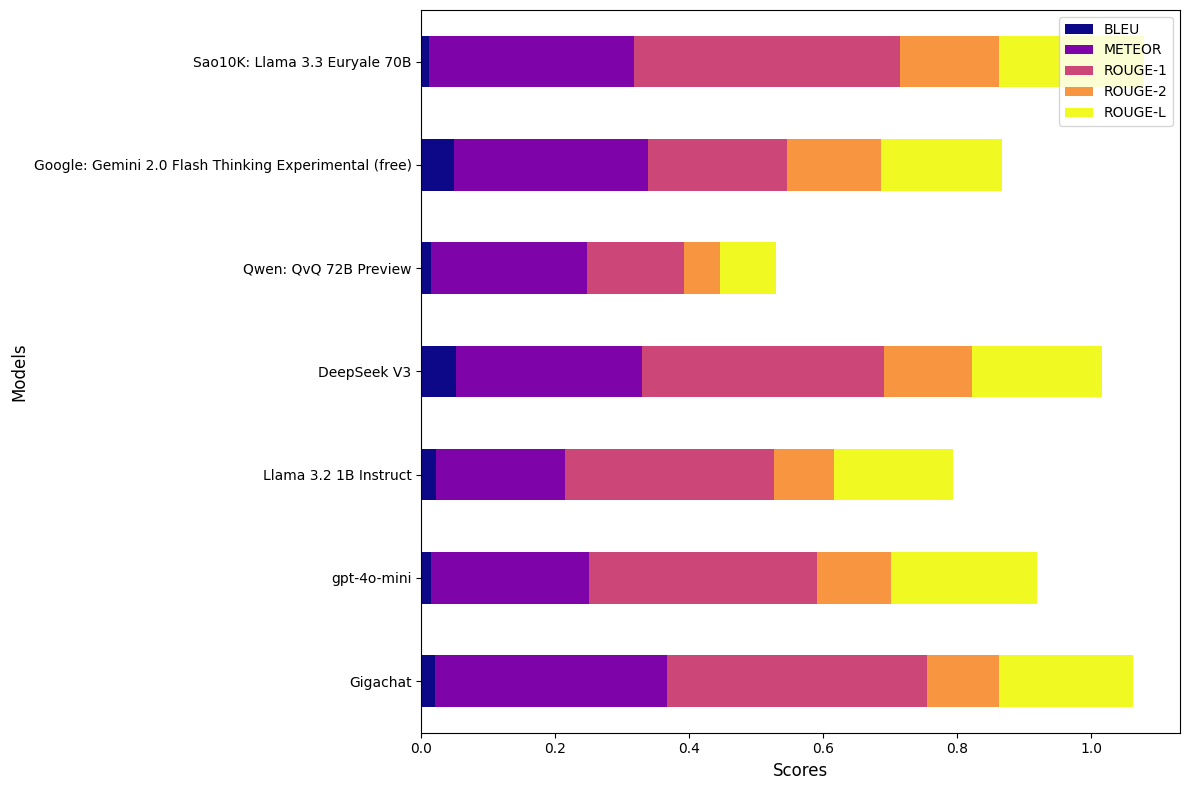

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = metrics_df
plt.figure(figsize=(16, 6))
df.set_index('Model').plot(kind='barh', stacked=True, figsize=(12, 8), colormap='plasma')

plt.xlabel('Scores', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.tight_layout()

plt.show()


# С векторной БД

In [ ]:
pip install faiss-gpu -q

ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu


In [ ]:
pip install faiss-cpu -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 63.7 MB/s eta 0:00:00


In [ ]:
pip install -U langchain-community rouge-score hnswlib -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import faiss  # Импорт библиотеки Faiss
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import requests
import json
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from google.colab import userdata

In [ ]:
# Загрузка данных
df = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-bioasq/data/passages.parquet/part.0.parquet")
df_test = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-bioasq/data/test.parquet/part.0.parquet")


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
# Инициализация OpenRouter API
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

def query_openrouter(model, prompt):
    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json",
    }
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ]
    }
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers=headers,
        data=json.dumps(data)
    )
    if response.status_code == 200:
        data = response.json()
        return data.get("choices", [{}])[0].get("message", {}).get("content", "No content returned")
    else:
        raise ValueError(f"Error {response.status_code}: {response.text}")


# Подготовка векторной базы данных Faiss
def create_faiss_index(corpus):
    vectorizer = TfidfVectorizer(stop_words="english", max_features=768)
    vectors = vectorizer.fit_transform(corpus).toarray()
    index = faiss.IndexFlatL2(vectors.shape[1])  # Создание векторного индекса
    index.add(np.array(vectors, dtype=np.float32))  # Добавление векторов в индекс
    return index, vectorizer

faiss_index, vectorizer = create_faiss_index(df["passage"])

# Функция для извлечения релевантных документов
def retrieve_documents(query, index, vectorizer, k=5):
    query_vector = vectorizer.transform([query]).toarray().astype(np.float32)
    distances, indices = index.search(query_vector, k)
    return [df.iloc[i]["passage"] for i in indices[0]]

# Функция RAG
def perform_rag(question, model="deepseek/deepseek-chat", k=5):
    # Шаг 1: Ретривинг документов
    retrieved_docs = retrieve_documents(question, faiss_index, vectorizer, k)
    context = " ".join(retrieved_docs)

    # Шаг 2: Генерация ответа
    prompt = f"""
    Answer the user's question.
    Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
    Context: {context}
    Question: {question}
    Answer:"""
    response = query_openrouter(model, prompt)
    return response

# Сравнение метрик
def evaluate_responses(true_answer, generated_answer):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(true_answer, generated_answer)

    # BLEU
    smooth_fn = SmoothingFunction().method1
    true_tokens = true_answer.split()
    generated_tokens = generated_answer.split()
    bleu = sentence_bleu([true_tokens], generated_tokens, smoothing_function=smooth_fn)

    # METEOR
    meteor = meteor_score([true_tokens], generated_tokens)

    return {
        "ROUGE-1": rouge_scores["rouge1"].fmeasure,
        "ROUGE-2": rouge_scores["rouge2"].fmeasure,
        "ROUGE-L": rouge_scores["rougeL"].fmeasure,
        "BLEU": bleu,
        "METEOR": meteor
    }

# Основной пайплайн: проверяем только первые три вопроса
results = []
for i, row in df_test.head(3).iterrows():  # Используем .head(3) для первых трёх строк
    question = row["question"]
    true_answer = row["answer"]

    # Без RAG
    prompt_without_rag = f"""
    Answer the user's question.
    Question: {question}
    Answer:"""
    response_without_rag = query_openrouter("deepseek/deepseek-chat", prompt_without_rag)

    # С RAG
    response_with_rag = perform_rag(question)

    # Оценка
    metrics_without_rag = evaluate_responses(true_answer, response_without_rag)
    metrics_with_rag = evaluate_responses(true_answer, response_with_rag)

    results.append({
        "Question": question,
        "True Answer": true_answer,
        "Response without RAG": response_without_rag,
        "Response with RAG": response_with_rag,
        "Metrics without RAG": metrics_without_rag,
        "Metrics with RAG": metrics_with_rag
    })

# Создание DataFrame для визуализации
results_df = pd.DataFrame(results)
print(results_df)
query_openrouter

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                                            Question  \
0  Is Hirschsprung disease a mendelian or a multi...   
1  List signaling molecules (ligands) that intera...   
2                   Is the protein Papilin secreted?   

                                         True Answer  \
0  Coding sequence mutations in RET, GDNF, EDNRB,...   
1  The 7 known EGFR ligands  are: epidermal growt...   
2                Yes,  papilin is a secreted protein   

                                Response without RAG  \
0  Hirschsprung disease (HSCR) is primarily consi...   
1  The epidermal growth factor receptor (EGFR) in...   
2  As of the current scientific knowledge, there ...   

                                   Response with RAG  \
0  Hirschsprung disease is described as a heterog...   
1  Based on the context provided, the signaling m...   
2  The context does not provide any information a...   

                                 Metrics without RAG  \
0  {'ROUGE-1': 0.2635658914728682, 'ROUGE-2'

<function __main__.query_openrouter(model, prompt)>

In [ ]:
results_df

,Question,True Answer,Response without RAG,Response with RAG,Metrics without RAG,Metrics with RAG
0,Is Hirschsprung disease a mendelian or a multi...,"Coding sequence mutations in RET, GDNF, EDNRB,...",Hirschsprung disease (HSCR) is primarily consi...,Hirschsprung disease is described as a heterog...,"{'ROUGE-1': 0.2635658914728682, 'ROUGE-2': 0.0...","{'ROUGE-1': 0.2958579881656805, 'ROUGE-2': 0.0..."
1,List signaling molecules (ligands) that intera...,The 7 known EGFR ligands are: epidermal growt...,The epidermal growth factor receptor (EGFR) in...,"Based on the context provided, the signaling m...","{'ROUGE-1': 0.4716981132075472, 'ROUGE-2': 0.2...","{'ROUGE-1': 0.17964071856287425, 'ROUGE-2': 0...."
2,Is the protein Papilin secreted?,"Yes, papilin is a secreted protein","As of the current scientific knowledge, there ...",The context does not provide any information a...,"{'ROUGE-1': 0.10101010101010101, 'ROUGE-2': 0....","{'ROUGE-1': 0.24242424242424243, 'ROUGE-2': 0...."


In [ ]:
import faiss
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import requests
import json
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from google.colab import userdata
import nltk

# Загрузка необходимых ресурсов
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

# Загрузка данных
df = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-bioasq/data/passages.parquet/part.0.parquet")
df_test = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-bioasq/data/test.parquet/part.0.parquet")

# Инициализация OpenRouter API
OPENROUTER_API_KEY = userdata.get('OPEN_Router')

def query_openrouter(model, prompt):
    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json",
    }
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ]
    }
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers=headers,
        data=json.dumps(data)
    )
    if response.status_code == 200:
        data = response.json()
        return data.get("choices", [{}])[0].get("message", {}).get("content", "No content returned")
    else:
        raise ValueError(f"Error {response.status_code}: {response.text}")

# Подготовка векторной базы данных Faiss
def create_faiss_index(corpus):
    vectorizer = TfidfVectorizer(stop_words="english", max_features=768)
    vectors = vectorizer.fit_transform(corpus).toarray()
    index = faiss.IndexFlatL2(vectors.shape[1])  # Создание векторного индекса
    index.add(np.array(vectors, dtype=np.float32))  # Добавление векторов в индекс
    return index, vectorizer

faiss_index, vectorizer = create_faiss_index(df["passage"])

# Функция для извлечения релевантных документов
def retrieve_documents(query, index, vectorizer, k=5):
    query_vector = vectorizer.transform([query]).toarray().astype(np.float32)
    distances, indices = index.search(query_vector, k)
    return [df.iloc[i]["passage"] for i in indices[0]]

# Функция RAG
def perform_rag(question, index, vectorizer, model="deepseek/deepseek-chat", k=5):
    # Шаг 1: Ретривинг документов
    retrieved_docs = retrieve_documents(question, index, vectorizer, k)
    context = " ".join(retrieved_docs)

    # Шаг 2: Генерация ответа
    prompt = f"""
    Answer the user's question.
    Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
    Context: {context}
    Question: {question}
    Answer:"""
    response = query_openrouter(model, prompt)
    return response

# Сравнение метрик
def evaluate_responses(true_answer, generated_answer):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(true_answer, generated_answer)

    # BLEU
    smooth_fn = SmoothingFunction().method1
    true_tokens = true_answer.split()
    generated_tokens = generated_answer.split()
    bleu = sentence_bleu([true_tokens], generated_tokens, smoothing_function=smooth_fn)

    # METEOR
    meteor = meteor_score([true_tokens], generated_tokens)

    return {
        "ROUGE-1": rouge_scores["rouge1"].fmeasure,
        "ROUGE-2": rouge_scores["rouge2"].fmeasure,
        "ROUGE-L": rouge_scores["rougeL"].fmeasure,
        "BLEU": bleu,
        "METEOR": meteor
    }

# Основной пайплайн: проверяем первые 10 вопросов
results = []
for i, row in df_test.head(10).iterrows():
    question = row["question"]
    true_answer = row["answer"]

    # С RAG
    response_with_rag = perform_rag(question, faiss_index, vectorizer)

    # Оценка
    metrics_with_rag = evaluate_responses(true_answer, response_with_rag)
    results.append(metrics_with_rag)

# Средние значения по метрикам
avg_metrics = {metric: np.mean([res[metric] for res in results]) for metric in results[0].keys()}
avg_metrics["Vector Store"] = "Faiss"

# Создание итогового DataFrame
final_df = pd.DataFrame([avg_metrics])

# Упорядочивание столбцов
cols = ["Vector Store"] + [col for col in final_df.columns if col != "Vector Store"]
final_df = final_df[cols]

print(final_df)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


  Vector Store  ROUGE-1   ROUGE-2   ROUGE-L      BLEU    METEOR
0        Faiss  0.18875  0.069871  0.166558  0.030061  0.163259


In [ ]:
# Функция генерации без RAG
def perform_without_rag(question, model="deepseek/deepseek-chat"):
    prompt = f"""
    Answer the user's question directly based on your knowledge.
    Question: {question}
    Answer:"""
    response = query_openrouter(model, prompt)
    return response

# Сравнение метрик (функция уже определена ранее)
# def evaluate_responses(true_answer, generated_answer): ...

# Основной цикл: проверяем те же первые 10 вопросов для подхода без RAG
results_without_rag = []

for i, row in df_test.head(10).iterrows():
    question = row["question"]
    true_answer = row["answer"]

    # Генерация ответа без RAG
    response_without_rag = perform_without_rag(question)

    # Оценка метрик
    metrics_without_rag = evaluate_responses(true_answer, response_without_rag)
    results_without_rag.append(metrics_without_rag)

# Средние значения по метрикам для без RAG
avg_metrics_without_rag = {metric: np.mean([res[metric] for res in results_without_rag]) for metric in results_without_rag[0].keys()}
avg_metrics_without_rag["Vector Store"] = "Without RAG"

# Преобразование в строку DataFrame
new_row = pd.DataFrame([avg_metrics_without_rag])

# Добавление новой строки к существующему DataFrame
final_df = pd.concat([final_df, new_row], ignore_index=True)

# Упорядочивание столбцов
cols = ["Vector Store"] + [col for col in final_df.columns if col != "Vector Store"]
final_df = final_df[cols]

# Вывод обновленного DataFrame
print(final_df)


  Vector Store   ROUGE-1   ROUGE-2   ROUGE-L      BLEU    METEOR
0        Faiss  0.188750  0.069871  0.166558  0.030061  0.163259
1  Without RAG  0.275941  0.117323  0.211804  0.014378  0.205294


In [ ]:
import hnswlib

# Создание индекса HNSWlib
def create_hnsw_index(corpus, dim=768, space="l2"):
    vectorizer = TfidfVectorizer(stop_words="english", max_features=dim)
    vectors = vectorizer.fit_transform(corpus).toarray()

    index = hnswlib.Index(space=space, dim=dim)
    index.init_index(max_elements=len(vectors), ef_construction=200, M=16)
    index.add_items(vectors)

    return index, vectorizer

hnsw_index, vectorizer = create_hnsw_index(df["passage"])

def retrieve_documents_hnsw(query, index, vectorizer, k=5):
    query_vector = vectorizer.transform([query]).toarray()[0]
    labels, _ = index.knn_query(query_vector, k=k)

    # Приводим индексы к целым числам
    labels = labels[0].astype(int)

    # Проверяем, что df — это DataFrame и столбец "passage" существует
    assert isinstance(df, pd.DataFrame), "df должен быть pandas DataFrame"
    assert "passage" in df.columns, "Столбец 'passage' не найден в DataFrame"

    # Извлекаем документы
    return [df.iloc[i]["passage"] for i in labels]

# RAG с HNSWlib
def perform_rag_hnsw(question, index, vectorizer, model="deepseek/deepseek-chat", k=5):
    retrieved_docs = retrieve_documents_hnsw(question, index, vectorizer, k)
    context = " ".join(retrieved_docs)
    prompt = f"""
    Answer the user's question.
    Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
    Context: {context}
    Question: {question}
    Answer:"""
    response = query_openrouter(model, prompt)
    return response

# Подготовка данных и расчет метрик для HNSWlib
results_hnsw = []
for i, row in df_test.head(10).iterrows():
    question = row["question"]
    true_answer = row["answer"]
    response_with_rag_hnsw = perform_rag_hnsw(question, hnsw_index, vectorizer)
    metrics_with_rag_hnsw = evaluate_responses(true_answer, response_with_rag_hnsw)
    results_hnsw.append(metrics_with_rag_hnsw)

# Усреднение метрик
avg_metrics_hnsw = pd.DataFrame(results_hnsw).mean().to_dict()
avg_metrics_hnsw["Vector Store"] = "HNSWlib"

# Добавление строки к существующему DataFrame
new_row_hnsw = pd.DataFrame([avg_metrics_hnsw])
final_df = pd.concat([final_df, new_row_hnsw], ignore_index=True)

print(final_df)



  Vector Store   ROUGE-1   ROUGE-2   ROUGE-L      BLEU    METEOR
0        Faiss  0.188750  0.069871  0.166558  0.030061  0.163259
1  Without RAG  0.275941  0.117323  0.211804  0.014378  0.205294
2      HNSWlib  0.193187  0.080407  0.173523  0.024828  0.179901


In [ ]:
final_df

NameError: name 'final_df' is not defined

In [ ]:
pip install pinecone-client -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 6.2 MB/s eta 0:00:00


In [ ]:
from pinecone import Pinecone, ServerlessSpec
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Замените на ваш API-ключ
PineCONE_api=userdata.get('Pinecon')

# Создание клиента Pinecone
pc = Pinecone(api_key=PineCONE_api)

# Название индекса
index_name = "for-simple-rag"

# Создание индекса, если он ещё не создан
if index_name not in pc.list_indexes():
    pc.create_index(
        name=index_name,
        dimension=768,  # Размерность векторов
        metric="cosine",  # Метрика для поиска
        spec=ServerlessSpec(cloud="aws", region="us-east-1")  # Укажите ваш регион
    )

# Загрузка индекса
pinecone_index = pc.load_index(index_name)

# Пример данных
df = pd.DataFrame({"passage": ["This is a sample text.", "Another example sentence."]})

# Заполнение индекса Pinecone
vectorizer = TfidfVectorizer(stop_words="english", max_features=768)
vectors = vectorizer.fit_transform(df["passage"]).toarray()

# Добавление в Pinecone
for i, vector in enumerate(vectors):
    pinecone_index.upsert([(str(i), vector.tolist())])

# Функция для поиска документов в Pinecone
def retrieve_documents_pinecone(query, index, vectorizer, k=5):
    query_vector = vectorizer.transform([query]).toarray()[0]
    results = index.query(query_vector.tolist(), top_k=k, include_metadata=True)
    return [df.iloc[int(match["id"])]["passage"] for match in results["matches"]]

# RAG с Pinecone
def perform_rag_pinecone(question, index, vectorizer, model="deepseek/deepseek-chat", k=5):
    retrieved_docs = retrieve_documents_pinecone(question, index, vectorizer, k)
    context = " ".join(retrieved_docs)
    prompt = f"""
    Answer the user's question.
    Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
    Context: {context}
    Question: {question}
    Answer:"""
    response = query_openrouter(model, prompt)
    return response

# Пример данных для тестирования
df_test = pd.DataFrame({
    "question": ["What is the sample text?", "Provide an example sentence."],
    "answer": ["This is a sample text.", "Another example sentence."]
})

# Подготовка данных и расчет метрик
results_pinecone = []
for i, row in df_test.head(10).iterrows():
    question = row["question"]
    true_answer = row["answer"]
    response_with_rag_pinecone = perform_rag_pinecone(question, pinecone_index, vectorizer)
    metrics_with_rag_pinecone = evaluate_responses(true_answer, response_with_rag_pinecone)
    results_pinecone.append(metrics_with_rag_pinecone)

# Усреднение метрик
avg_metrics_pinecone = pd.DataFrame(results_pinecone).mean().to_dict()
avg_metrics_pinecone["Vector Store"] = "Pinecone"

# Добавление строки к существующему DataFrame
new_row_pinecone = pd.DataFrame([avg_metrics_pinecone])
final_df = pd.concat([final_df, new_row_pinecone], ignore_index=True)

print(final_df)



AttributeError: 'Pinecone' object has no attribute 'index'

# C векторной БД (сравнение моделей)

In [ ]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import faiss
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import requests
import json

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

# Загрузка данных
df = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-bioasq/data/passages.parquet/part.0.parquet")
df_test = pd.read_parquet("hf://datasets/rag-datasets/rag-mini-bioasq/data/test.parquet/part.0.parquet")
df_test['relevant_passage_ids'] = df_test['relevant_passage_ids'].apply(ast.literal_eval)

OPENROUTER_API_KEY = OPENROUTER_API_KEY = userdata.get('OPEN_Router')  # Укажите ваш ключ API

# Подготовка Faiss
def create_faiss_index(corpus):
    vectorizer = TfidfVectorizer(stop_words="english", max_features=768)
    vectors = vectorizer.fit_transform(corpus).toarray()
    index = faiss.IndexFlatL2(vectors.shape[1])  # Векторный индекс
    index.add(np.array(vectors, dtype=np.float32))  # Добавление векторов
    return index, vectorizer

faiss_index, vectorizer = create_faiss_index(df["passage"])

def retrieve_documents(query, index, vectorizer, k=5):
    query_vector = vectorizer.transform([query]).toarray().astype(np.float32)
    distances, indices = index.search(query_vector, k)
    return [df.iloc[i]["passage"] for i in indices[0]]

# Функция для вызова OpenRouter
def query_openrouter(model, prompt):
    headers = {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json",
    }
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ]
    }
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers=headers,
        data=json.dumps(data)
    )
    if response.status_code == 200:
        data = response.json()
        return data.get("choices", [{}])[0].get("message", {}).get("content", "No content returned")
    else:
        raise ValueError(f"Error {response.status_code}: {response.text}")

# RAG
def perform_rag(question, model="deepseek/deepseek-chat", k=5):
    retrieved_docs = retrieve_documents(question, faiss_index, vectorizer, k)
    context = " ".join(retrieved_docs)
    prompt = f"""
    Answer the user's question.
    Use only the information from the context. If the context does not contain enough information to answer the question, let the user know.
    Context: {context}
    Question: {question}
    Answer:"""
    return query_openrouter(model, prompt)

# Метрики
def evaluate_responses(true_answer, generated_answer):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(true_answer, generated_answer)
    smooth_fn = SmoothingFunction().method1
    true_tokens = true_answer.split()
    generated_tokens = generated_answer.split()
    bleu = sentence_bleu([true_tokens], generated_tokens, smoothing_function=smooth_fn)
    meteor = meteor_score([true_tokens], generated_tokens)
    return {
        "ROUGE-1": rouge_scores["rouge1"].fmeasure,
        "ROUGE-2": rouge_scores["rouge2"].fmeasure,
        "ROUGE-L": rouge_scores["rougeL"].fmeasure,
        "BLEU": bleu,
        "METEOR": meteor
    }

# Модели
models = [
    "meta-llama/llama-3.2-1b-instruct",
    "deepseek/deepseek-chat",
    "qwen/qvq-72b-preview",
    "google/gemini-2.0-flash-thinking-exp:free",
    "sao10k/l3.3-euryale-70b"
]

# Основной цикл
columns = ["Model", "Question", "BLEU", "METEOR", "ROUGE-1", "ROUGE-2", "ROUGE-L"]
metrics_df = pd.DataFrame(columns=columns)

for model in models:
    for _, row in df_test.head(1).iterrows():  # Ограничиваемся первыми тремя вопросами
        question = row["question"]
        true_answer = row["answer"]
        response = perform_rag(question, model=model)
        metrics = evaluate_responses(true_answer, response)
        metrics_df = pd.concat([metrics_df, pd.DataFrame([{
            "Model": model,
            "Question": question,
            **metrics
        }])], ignore_index=True)


In [ ]:
metrics_df_VB = metrics_df

<Figure size 1600x600 with 0 Axes>

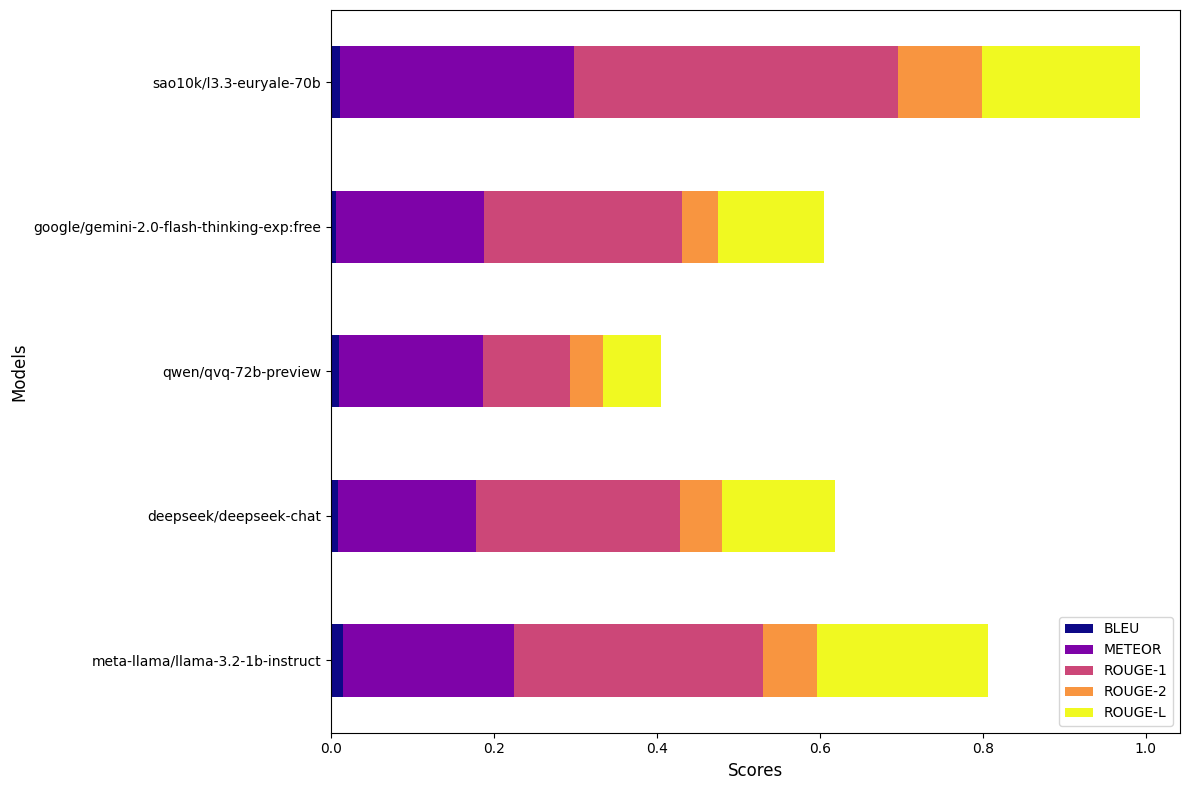

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = metrics_df_VB
plt.figure(figsize=(16, 6))
df.set_index('Model').plot(kind='barh', stacked=True, figsize=(12, 8), colormap='plasma')

plt.xlabel('Scores', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.tight_layout()

plt.show()

<Figure size 1600x600 with 0 Axes>

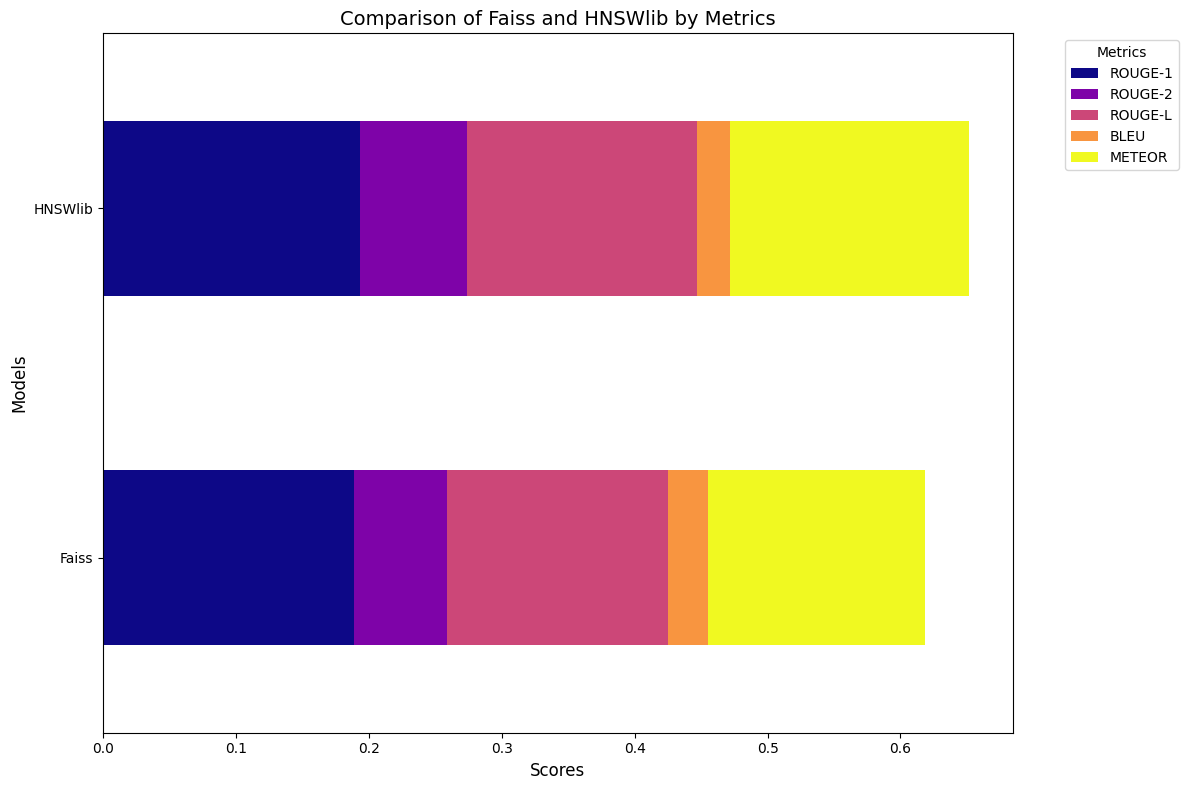

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Ваш датафрейм
data = {
    'Vector Store': ['Faiss', 'Without RAG', 'HNSWlib'],
    'ROUGE-1': [0.188750, 0.275941, 0.193187],
    'ROUGE-2': [0.069871, 0.117323, 0.080407],
    'ROUGE-L': [0.166558, 0.211804, 0.173523],
    'BLEU': [0.030061, 0.014378, 0.024828],
    'METEOR': [0.163259, 0.205294, 0.179901]
}

df = pd.DataFrame(data)

# Фильтрация данных для Faiss и HNSWlib
df_filtered = df[df['Vector Store'].isin(['Faiss', 'HNSWlib'])]

# Установка 'Vector Store' в качестве индекса
df_filtered.set_index('Vector Store', inplace=True)

# Построение графика
plt.figure(figsize=(16, 6))
df_filtered.plot(kind='barh', stacked=True, colormap='plasma', figsize=(12, 8))

# Настройка графика
plt.xlabel('Scores', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.title('Comparison of Faiss and HNSWlib by Metrics', fontsize=14)
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')  # Легенда с метриками
plt.tight_layout()

plt.show()

<Figure size 2000x600 with 0 Axes>

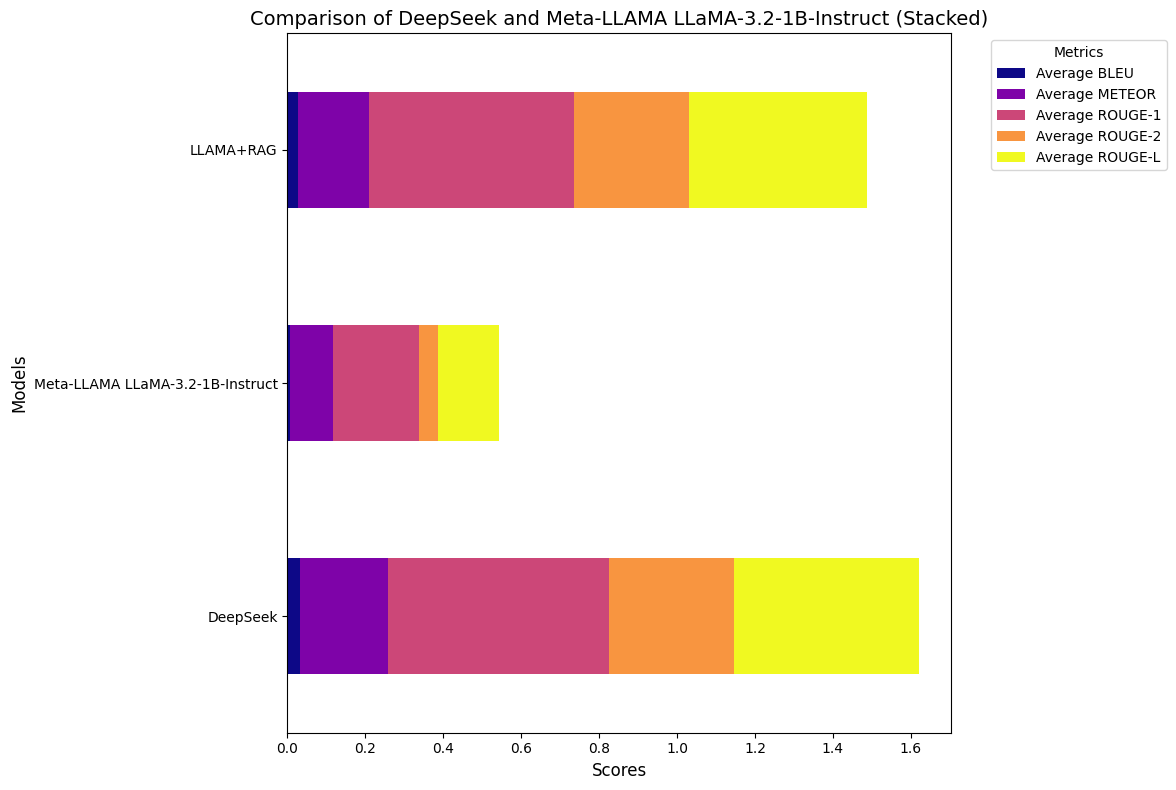

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Данные для моделей
data = {
    'Model': ['DeepSeek', 'Meta-LLAMA LLaMA-3.2-1B-Instruct', 'LLAMA+RAG'],
    'Average BLEU': [0.031632659588777055, 0.00652274632509797, 0.0261],
    'Average METEOR': [0.22620634043506715, 0.10966738288724649, 0.1829],
    'Average ROUGE-1': [0.5680318596273058, 0.22154851372717949, 0.5269],
    'Average ROUGE-2': [0.32083970345568236, 0.04814424950759733, 0.2958],
    'Average ROUGE-L': [0.4755375176839518, 0.15732979652892995,0.4554]
}

# Создание DataFrame
df = pd.DataFrame(data)

# Установка 'Model' в качестве индекса
df.set_index('Model', inplace=True)

# Построение горизонтального столбчатого графика с накоплением
plt.figure(figsize=(20, 6))
df.plot(kind='barh', stacked=True, colormap='plasma', figsize=(12, 8))

# Настройка графика
plt.xlabel('Scores', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.title('Comparison of DeepSeek and Meta-LLAMA LLaMA-3.2-1B-Instruct (Stacked)', fontsize=14)
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')  # Легенда с метриками
plt.tight_layout()

plt.show()